In [42]:
%matplotlib inline
import cv2 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import os
from skimage.filters import threshold_otsu
from skimage import exposure, img_as_float, img_as_ubyte
from scipy import ndimage
from PIL import Image
import time
from scipy.ndimage.measurements import label


In [20]:
def strech_contrast(img,A=0.15,B=0.65,SA=0.3,SB=0.9):
    # Stech Contrast of Grayscale Image

    img_float = img_as_float(img)  # Scale into range [0, 1] of float

    mask_left = (img_float < A)
    mask_center = ((img_float >= A) & (img_float < B))  
    mask_right = (img_float >= B)

    img_cont = np.copy(img_float)          
    img_cont[mask_left]   = img_float[mask_left] * SA / A
    img_cont[mask_center] = SA + (img_float[mask_center]-A) * (SB - SA) / (B - A)
    img_cont[mask_right] = SB + (img_float[mask_right]-B) * (1. - SB) / (1. - B)
    img_cont = img_as_ubyte(img_cont)
    
    return img_cont

In [26]:
def detect_object(img , FILTER_LEN=800 , FILTER_WID=5):
    # Detect Objectbounds
    kernel = np.ones((FILTER_LEN,FILTER_WID), dtype=np.uint8)
    img_centery = img.shape[0]//2 # vertical img center
    pixel_pos = []
    for i in range(FILTER_WID//2 + 1 , img.shape[1] - FILTER_WID//2):
        result = kernel * img[img_centery - FILTER_LEN//2 : img_centery + FILTER_LEN//2 , i-FILTER_WID//2 : i+FILTER_WID//2 + 1 ]
        if np.sum(result) < FILTER_WID*FILTER_LEN*200:
            pixel_pos.append(i)            
    edge_left = pixel_pos[0] - 10
    edge_right = pixel_pos[-1] + 10
    
    return (edge_left,edge_right)

In [15]:
# read image
path = '/Users/meko/Downloads/Technoform_profiles/Profil_1/'
im_id = 'Basler_acA3088-57uc__23186829__20200218_120749566_1.bmp'
img = cv2.imread(path + im_id)

In [27]:
# Convert to grayscale
img_g = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # to gray
CROP_BOUNDX = 300
CROP_BOUNDY = 300
img_g_crop = img_g[CROP_BOUNDY:-CROP_BOUNDY,CROP_BOUNDX:-CROP_BOUNDX]
print('shape: ', img_g_crop.shape)

shape:  (1464, 2488)


In [28]:
# Contrast Streching
img_g_cont = strech_contrast(img_g_crop)

In [30]:
# Detect Object
edges = detect_object(img_g_cont)
width = edges[1]-edges[0]

In [33]:
# Cut out Object
img_out = img[:,edges[0]+CROP_BOUNDX:edges[1]+CROP_BOUNDX,:]

In [36]:
# Adjust Contrast
CLIP_LIMIT = 0.015
img_out = exposure.equalize_adapthist(img_out,clip_limit = CLIP_LIMIT) 
img_out = img_as_ubyte(img_out) # equalize_adapthist converst image to float64

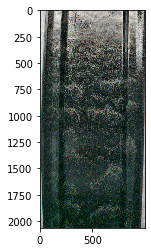

In [37]:
plt.imshow(img_out)
plt.show()

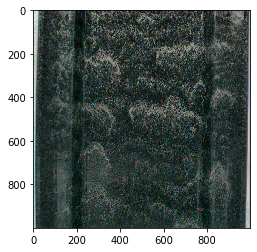

In [41]:
# Cut out AOI
img_out_aoi = img_out[500:1500,:,:]
plt.imshow(img_out_aoi)
plt.show()

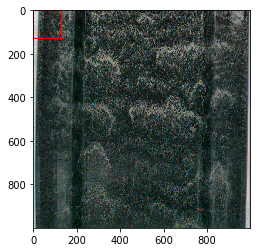

In [47]:
fig,ax = plt.subplots(1)
ax.imshow(img_out_aoi)
rect = patches.Rectangle((0,0),128,128,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [179]:
# Cont4
img_cont4 = exposure.equalize_adapthist(img_g_crop,clip_limit=0.015)

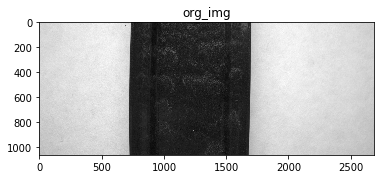

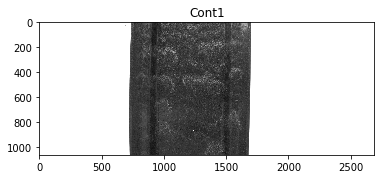

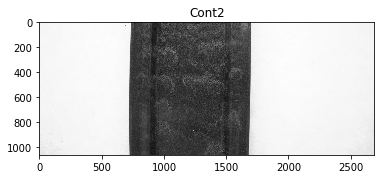

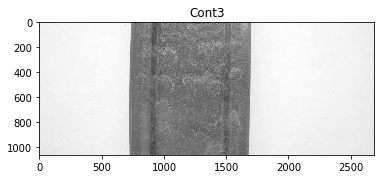

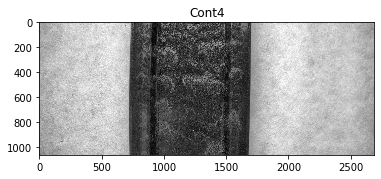

In [180]:
plt.figure(1)
plt.imshow(img_g_crop,cmap='gray')
plt.title('org_img')
plt.figure(2)
plt.imshow(img_cont1, cmap='gray')
plt.title('Cont1')
plt.figure(4)
plt.imshow(img_as_ubyte(img_cont2), cmap='gray')
plt.title('Cont2')
plt.show();
plt.imshow(img_as_ubyte(img_cont3), cmap='gray')
plt.title('Cont3')
plt.show();
plt.imshow(img_as_ubyte(img_cont4), cmap='gray')
plt.title('Cont4')
plt.show();

In [78]:
np.max(img_cont2)

0.9137254901960784

In [141]:
# Naive Edge Detection
filter_len = 100
filter_wid = 5
kernel = np.ones((filter_len,filter_wid), dtype=np.uint8)
img_mid = img_cont2.shape[1]//2
pixel_pos = []
for i in range(filter_wid//2 + 1 , img_cont2.shape[1] - filter_wid//2):
    result = kernel * img_cont2[img_mid - filter_len//2 : img_mid + filter_len//2 , i-filter_wid//2 : i+filter_wid//2 + 1 ]
    if np.sum(result) < filter_len*filter_wid*200:
        pixel_pos.append(i)
bound_left = pixel_pos[0] + crop_bound_x - 10
bound_right = pixel_pos[-1] + crop_bound_x + 10


ValueError: operands could not be broadcast together with shapes (100,5) (0,5) 

(1064, 2688)


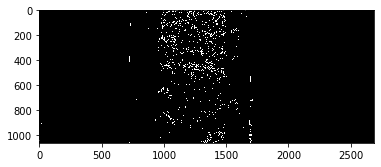

In [82]:
######Canny EDGE DETECTION######

edges = cv2.Canny(img_as_ubyte(img_cont2),20,60,apertureSize = 3)
print(edges.shape)

kernel = np.array([[0,1,2,1,0], 
                    [0,1,2,1,0], 
                    [0,1,2,1,0], 
                    [0,1,2,1,0], 
                    [0,1,2,1,0],
                    [0,1,2,1,0],
                    [0,1,0,1,0],
                    [0,1,2,1,0],
                    [0,1,2,1,0],
                    [0,1,2,1,0],
                    [0,1,2,1,0],
                    [0,1,2,1,0],
                    [0,1,2,1,0]])

kernel = kernel[2:-2,:]
kernel_r = kernel.shape[0] # =9
kernel_c = kernel.shape[1] # =5
edges2 = np.zeros(img_g_crop.shape)
print('start loop')
for i in range((kernel_r-1)//2,img_g_crop.shape[0]-(kernel_r-1)//2 -1):
    for j in range((kernel_c-1)//2,img_g_crop.shape[1]-(kernel_c-1)//2 -1):
        end_j = j + ((kernel_c-1)//2 +1)
        start_j = j-(kernel_c-1)//2
        local_pixels = edges[i-(kernel_r-1)//2:i+(kernel_r-1)//2 + 1 , start_j : end_j]
        result = local_pixels * kernel
        a=np.sum(result)
        edges2[i,j] = np.sum(result)
        #if edges2[i,j] < 1500:
        #    edges2[i,j] = 0
print('end loop')
plt.figure(2)
plt.imshow(edges2,cmap='gray')
plt.title('edges2')

plt.imshow(edges, cmap='gray')
plt.show()

(21672, 1, 2)


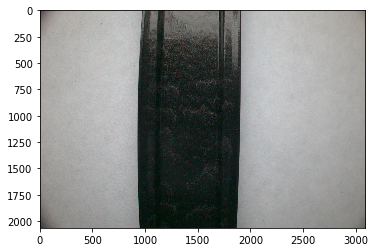

In [63]:
#####Detect Object####

# Hough transform
rho = 1
theta = np.pi/(180)   
threshold = 200
edges2 = np.uint8(edges2)
lines = cv2.HoughLines(edges2,rho,theta,threshold)
print(lines.shape)

for rho,theta in lines[i]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img_g_crop,(x1,y1),(x2,y2),(255,255,255),20)

cv2.imwrite('linesn.jpg',img)
lines_i = cv2.imread('linesn.jpg')
plt.figure(2)
plt.imshow(lines_i)

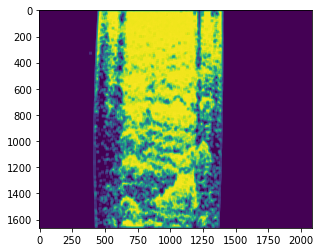

In [98]:
edges2_d = cv2.fastNlMeansDenoising(edges2,h=1000)
plt.imshow(edges2_d)